# **Introduction 📱**
The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

### **Interconnect's services**
* Landline communication. The telephone can be connected to several lines simultaneously.
* Internet. The network can be set up via a telephone line (DSL, digital subscriber line) or through a fiber optic cable.
* Internet security: antivirus software (DeviceProtection) and a malicious website blocker (OnlineSecurity)
* A dedicated technical support line (TechSupport)
* Cloud file storage and data backup (OnlineBackup)
*  TV streaming (StreamingTV) and a movie directory (StreamingMovies)



## **Initialization** 🚀

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, roc_curve

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.inspection import permutation_importance
import seaborn as sns

In [ ]:
contract = pd.read_csv('contract.csv')
personal = pd.read_csv('personal.csv')
internet = pd.read_csv('internet.csv')
phone = pd.read_csv('phone.csv')

In [ ]:
def qa_check(df):
    print(f"Checking {df.shape[0]} rows and {df.shape[1]} columns in DataFrame...")

    # Check data structure
    df.info()

    # Check for duplicates
    dup_count = df.duplicated().sum()
    print()
    print(f"Duplicates found: {dup_count}")
    print()

    # Count zeros
    zero_cols = {}
    for col in df.columns:
        zero_count = (df[col] == 0).sum()
        if zero_count > 0:
            zero_cols[col] = zero_count
    print("Columns with zeros:")
    for col, count in zero_cols.items():
        print(f"  {col}: {count}")
    print()

    # Count null/nan and inf/-inf
    nan_cols = {}
    for col in df.columns:
        df_inf = df[col].replace([np.inf, -np.inf], np.nan)
        nan_count = df_inf.isnull().sum()
        if nan_count > 0:
            nan_cols[col] = nan_count
    print("Columns with null/NaN values:")
    for col, count in nan_cols.items():
        print(f"  {col}: {count}")
    print()

qa_check(contract)
print()
qa_check(personal)
print()
qa_check(internet)
print()
qa_check(phone)
print()

Checking 7043 rows and 8 columns in DataFrame...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

Duplicates found: 0

Columns with zeros:

Columns with null/NaN values:


Checking 7043 rows and 5 columns in DataFrame...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   

In [ ]:
print(contract.head(5))
print()
print(personal.head(5))
print()
print(internet.head(5))
print()
print(phone.head(5))
print()

   customerID   BeginDate  ... MonthlyCharges TotalCharges
0  7590-VHVEG  2020-01-01  ...          29.85        29.85
1  5575-GNVDE  2017-04-01  ...          56.95       1889.5
2  3668-QPYBK  2019-10-01  ...          53.85       108.15
3  7795-CFOCW  2016-05-01  ...          42.30      1840.75
4  9237-HQITU  2019-09-01  ...          70.70       151.65

[5 rows x 8 columns]

   customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

   customerID InternetService OnlineSecurity  ... TechSupport StreamingTV StreamingMovies
0  7590-VHVEG             DSL             No  ...          No          No              No
1  5575-GNVDE             DSL            Yes  ...          No          No              No
2  3668-QPYBK   

**Comment:**

After the initialization and quality check, we see that none of the datasets include data that will be a issue to pre-process. However, based on previous experience, the datetime and objects data types may prove to be challenging. There is also the approach of encoding which needs to be applied to improve the model performance. My determination is that we are clear to proceed with the next section.

## **Feature Engineering I**

In [ ]:
# Convert BeginDate from YYYY-MM-DD to datetime
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')

# Replace 'No' with NaT in EndDate
contract['EndDate'] = contract['EndDate'].replace('No', pd.NaT)

# Convert EndDate to datetime (allowing for mixed formats)
contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce')

# Calculate the duration and store it in a new column 'Duration'
contract['Duration'] = contract['EndDate'] - contract['BeginDate']

# Display the updated DataFrame
print("\nDataFrame with Duration:")
print(contract)


DataFrame with Duration:
      customerID  BeginDate    EndDate  ... MonthlyCharges TotalCharges Duration
0     7590-VHVEG 2020-01-01        NaT  ...          29.85        29.85      NaT
1     5575-GNVDE 2017-04-01        NaT  ...          56.95       1889.5      NaT
2     3668-QPYBK 2019-10-01 2019-12-01  ...          53.85       108.15  61 days
3     7795-CFOCW 2016-05-01        NaT  ...          42.30      1840.75      NaT
4     9237-HQITU 2019-09-01 2019-11-01  ...          70.70       151.65  61 days
...          ...        ...        ...  ...            ...          ...      ...
7038  6840-RESVB 2018-02-01        NaT  ...          84.80       1990.5      NaT
7039  2234-XADUH 2014-02-01        NaT  ...         103.20       7362.9      NaT
7040  4801-JZAZL 2019-03-01        NaT  ...          29.60       346.45      NaT
7041  8361-LTMKD 2019-07-01 2019-11-01  ...          74.40        306.6 123 days
7042  3186-AJIEK 2014-08-01        NaT  ...         105.65       6844.5      NaT

[

In [ ]:
# Merge dataframes on ['CustomerID']
# Perform right outer joins
interconnect_customer_data = (
    contract.merge(personal, on='customerID', how='right')
             .merge(internet, on='customerID', how='right')
             .merge(phone, on='customerID', how='right')
)

print(interconnect_customer_data.head(5))
print()
print(interconnect_customer_data.info())

   customerID  BeginDate    EndDate  ... StreamingTV StreamingMovies MultipleLines
0  5575-GNVDE 2017-04-01        NaT  ...          No              No            No
1  3668-QPYBK 2019-10-01 2019-12-01  ...          No              No            No
2  9237-HQITU 2019-09-01 2019-11-01  ...          No              No            No
3  9305-CDSKC 2019-03-01 2019-11-01  ...         Yes             Yes           Yes
4  1452-KIOVK 2018-04-01        NaT  ...         Yes              No           Yes

[5 rows x 21 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   customerID        6361 non-null   object         
 1   BeginDate         4835 non-null   datetime64[ns] 
 2   EndDate           1586 non-null   datetime64[ns] 
 3   Type              4835 non-null   object         
 4   PaperlessBilling  4835 non-null   ob

In [ ]:
# Drop the 'CustomerID' column
interconnect_customer_data = interconnect_customer_data.drop(columns=['customerID'])

In [ ]:
# Create a new boolean column 'Churn' based on EndDate
interconnect_customer_data['Churn'] = interconnect_customer_data['EndDate'].notna()

# Optionally, drop the EndDate column if no longer needed
interconnect_customer_data.drop('EndDate', axis=1, inplace=True)

# Display the updated DataFrame
print(interconnect_customer_data)

      BeginDate            Type PaperlessBilling  ... StreamingMovies  MultipleLines  Churn
0    2017-04-01        One year               No  ...              No             No  False
1    2019-10-01  Month-to-month              Yes  ...              No             No   True
2    2019-09-01  Month-to-month              Yes  ...              No             No   True
3    2019-03-01  Month-to-month              Yes  ...             Yes            Yes   True
4    2018-04-01  Month-to-month              Yes  ...              No            Yes  False
...         ...             ...              ...  ...             ...            ...    ...
6356        NaT             NaN              NaN  ...             NaN             No  False
6357 2018-02-01        One year              Yes  ...             Yes            Yes  False
6358 2014-02-01        One year              Yes  ...             Yes            Yes  False
6359 2019-07-01  Month-to-month              Yes  ...              No           

**Comment:**

My approach to feature engineering was to address the two datatype concerns, where the first was due to the YYYY-MM-DD format as an object to datetime for calculations, then use EndDate to create a new field called ['Duration']. Next, I dropped ['customerID'] because this field is a random kind of index. Lastly, I created a field called ['Churn'] based on ['EndDate'] and dropped ['EndDate'], because it didn't make sense why this date would influence whether a customer would churn.

## **Exploratory Data Analysis**

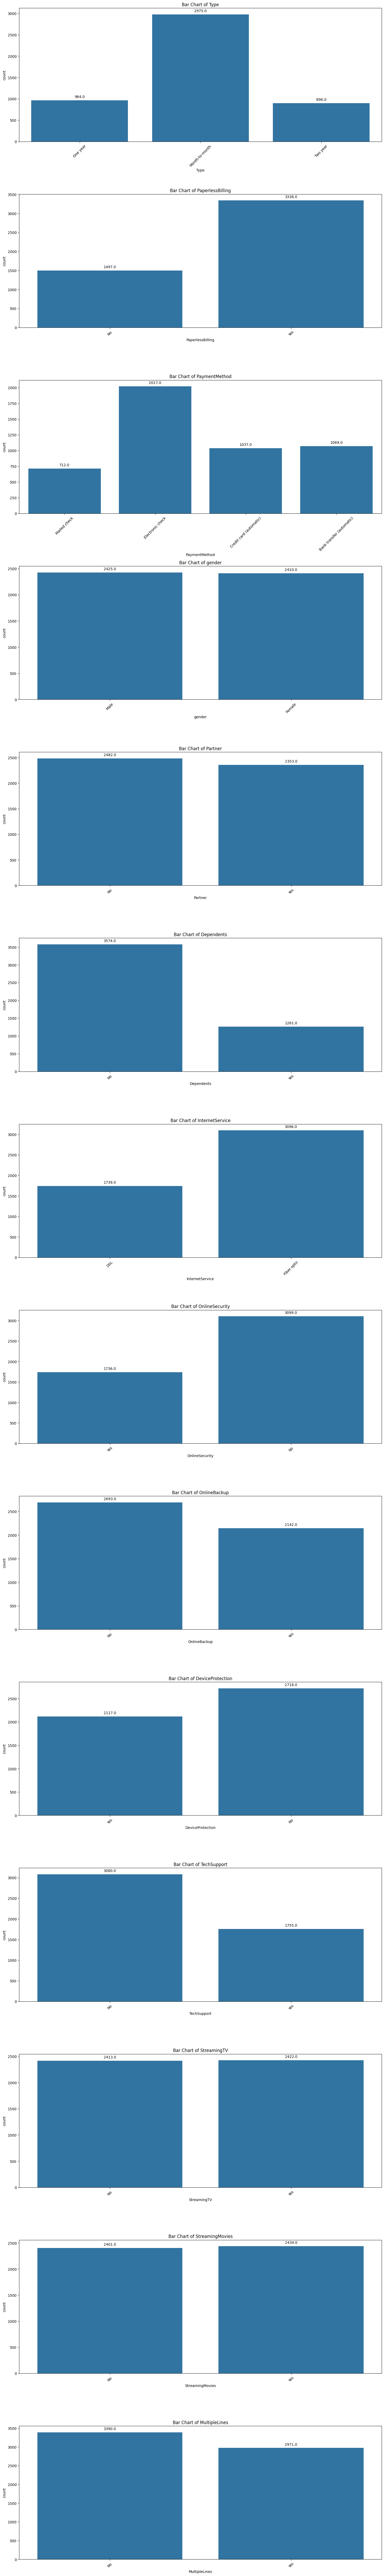

In [ ]:
# Bar charts for categorical columns
categorical_columns = [
    'Type',
    'PaperlessBilling',
    'PaymentMethod',
    'gender',
    'Partner',
    'Dependents',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'MultipleLines'
]

# Set figure size to increase height
plt.figure(figsize=(15, 100))  # Adjusted height

for i, col in enumerate(categorical_columns):
    plt.subplot(len(categorical_columns), 1, i + 1)
    ax = sns.countplot(data=interconnect_customer_data, x=col)
    plt.title(f'Bar Chart of {col}')
    plt.xticks(rotation=45)

    # Adding data labels
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10, color='black',
                    xytext=(0, 5),  # 5 points vertical offset
                    textcoords='offset points')

plt.tight_layout()
plt.show()

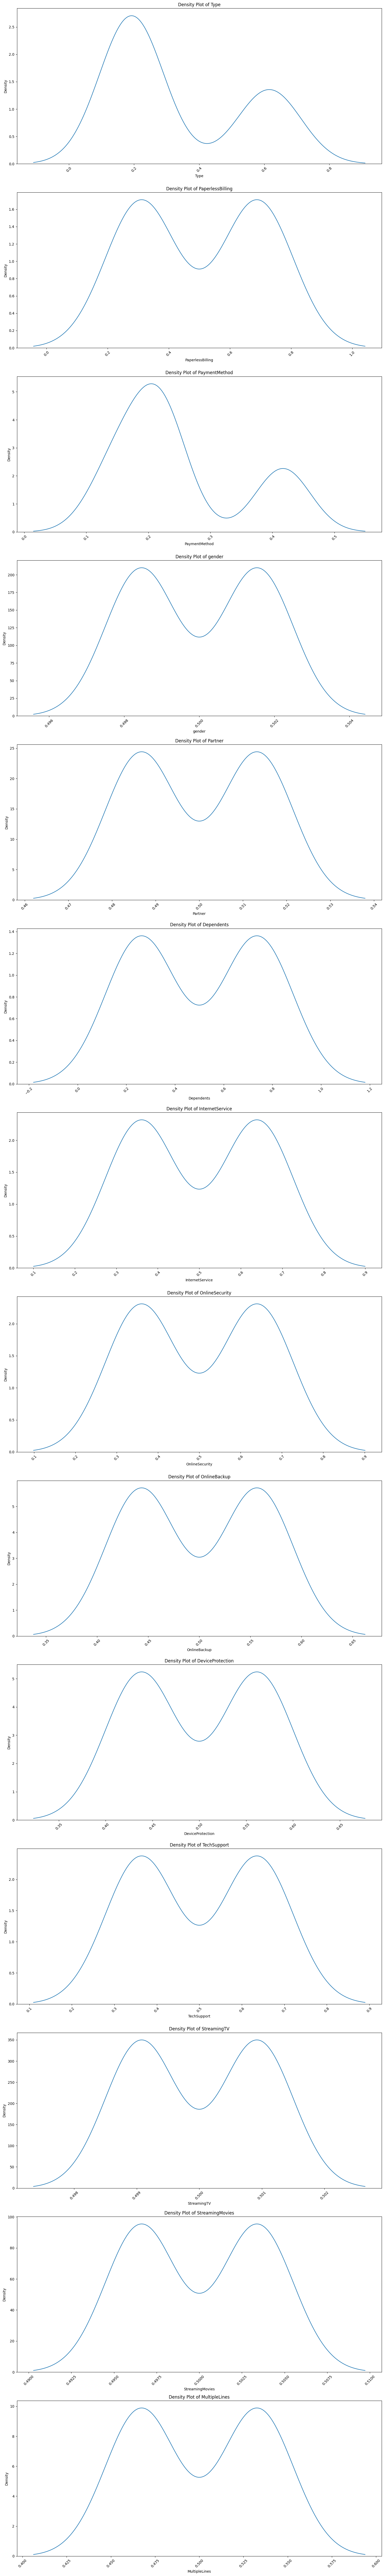

In [ ]:
# Set figure size to increase height
plt.figure(figsize=(15, 100))  # Adjusted height

for i, col in enumerate(categorical_columns):
    plt.subplot(len(categorical_columns), 1, i + 1)

    # Calculate counts and create a density-like plot
    counts = interconnect_customer_data[col].value_counts(normalize=True)
    sns.kdeplot(counts, bw_adjust=0.5)  # Using kdeplot to visualize density
    plt.title(f'Density Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**Comment:**


Results from the data exploration show that the classes are relatively balanced compared to other datasets that I've worked with, so I do not anticipate the use over up- or downsampling. The visualizations demonstrate the two states of the variables, so things are checking out smoothly so far.

## **Feature Engineering II**

In [ ]:
# List of columns to encode
columns_to_encode = [
    'Type',
    'PaperlessBilling',
    'PaymentMethod',
    'gender',
    'Partner',
    'Dependents',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'MultipleLines'
]

# Apply One-Hot Encoding to the specified columns
interconnect_customer_data = pd.get_dummies(interconnect_customer_data, columns=columns_to_encode, drop_first=True)

# Display the updated DataFrame
print(interconnect_customer_data.info())
print(interconnect_customer_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype          
---  ------                                 --------------  -----          
 0   BeginDate                              4835 non-null   datetime64[ns] 
 1   MonthlyCharges                         4835 non-null   float64        
 2   TotalCharges                           4835 non-null   object         
 3   Duration                               1586 non-null   timedelta64[ns]
 4   SeniorCitizen                          4835 non-null   float64        
 5   Churn                                  6361 non-null   bool           
 6   Type_One year                          6361 non-null   bool           
 7   Type_Two year                          6361 non-null   bool           
 8   PaperlessBilling_Yes                   6361 non-null   bool           
 9   PaymentMethod_Credit card (automatic)  6361 non-null

In [ ]:
# Check the data types of the features
print(interconnect_customer_data.dtypes)

BeginDate                                 datetime64[ns]
MonthlyCharges                                   float64
TotalCharges                                      object
Duration                                 timedelta64[ns]
SeniorCitizen                                    float64
Churn                                               bool
Type_One year                                       bool
Type_Two year                                       bool
PaperlessBilling_Yes                                bool
PaymentMethod_Credit card (automatic)               bool
PaymentMethod_Electronic check                      bool
PaymentMethod_Mailed check                          bool
gender_Male                                         bool
Partner_Yes                                         bool
Dependents_Yes                                      bool
InternetService_Fiber optic                         bool
OnlineSecurity_Yes                                  bool
OnlineBackup_Yes               

In [ ]:
# Convert BeginDate to timestamp
interconnect_customer_data['BeginDate'] = interconnect_customer_data['BeginDate'].astype(int) / 10**9  # Convert to seconds since epoch

# Convert TotalCharges to numeric, forcing errors to NaN
interconnect_customer_data['TotalCharges'] = pd.to_numeric(interconnect_customer_data['TotalCharges'], errors='coerce')

# Convert Duration to total seconds
interconnect_customer_data['Duration'] = interconnect_customer_data['Duration'].dt.total_seconds()

In [ ]:
# Initialize KNN Imputer
imputer = KNNImputer(n_neighbors=3)

# Select columns to impute (excluding 'BeginDate')
columns_to_impute = interconnect_customer_data.columns.difference(['BeginDate'])

# Apply KNN Imputer
interconnect_customer_data[columns_to_impute] = imputer.fit_transform(interconnect_customer_data[columns_to_impute])

# Check the DataFrame after imputation
print(interconnect_customer_data)

         BeginDate  MonthlyCharges  ...  StreamingMovies_Yes  MultipleLines_Yes
0     1.491005e+09       56.950000  ...                  0.0                0.0
1     1.569888e+09       53.850000  ...                  0.0                0.0
2     1.567296e+09       70.700000  ...                  0.0                0.0
3     1.551398e+09       99.650000  ...                  1.0                1.0
4     1.522541e+09       89.100000  ...                  0.0                1.0
...            ...             ...  ...                  ...                ...
6356 -9.223372e+09       94.416667  ...                  0.0                0.0
6357  1.517443e+09       84.800000  ...                  1.0                1.0
6358  1.391213e+09      103.200000  ...                  1.0                1.0
6359  1.561939e+09       74.400000  ...                  0.0                1.0
6360  1.406851e+09      105.650000  ...                  1.0                0.0

[6361 rows x 23 columns]


**Comment:**

Next, I revisited the feature engineering by implementing two encoding methods for two separate reasons. The first was a one hot encoding which I determined would be better than label encoding in this case because many of the fields have only two classes. The next approach I used was KNN Imputer to fill the gaps in the dataset that were present as 'NaT' from some of the pre-processing adjustments needed.

## **Model Evaluation**

* **Logistic Regression** - Logistic regression builds upon linear regression, which models a continuous relationship between variables. To map the linear regression output to a probability between 0 and 1, we apply the sigmoid function. The output of the sigmoid function represents the probability of the positive class (e.g., email being spam). A threshold is set (often 0.5) to classify instances.
      # https://scikit-learn.org/dev/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

* **Random Forest Regressor** – a regression algorithm that uses an ensemble of decision trees to predict continuous numerical values. It is similar to the Random Forest Classifier, but instead of predicting class labels, it predicts a real number.
      # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

* **XGBoost Regressor** – a supervised learning algorithm that uses gradient boosting to train a model for regression problems. It is a popular choice for regression tasks due to its high accuracy and efficiency.
      # https://xgboost.readthedocs.io/en/stable/python/index.html


In [ ]:
# Define features and target
features = interconnect_customer_data.drop(['Churn'], axis=1)  # Features
target = interconnect_customer_data['Churn']  # Target variable

# Split the dataset into training and testing sets
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [ ]:
model1 = LogisticRegression()
model2 = RandomForestClassifier()
model3 = XGBClassifier()

In [ ]:
# Set up the logistic regression model
# Define the parameter grid for hyperparameter tuning
param_grid1 = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'saga'],  # Solvers to consider
    'max_iter': [100, 200, 300],  # Maximum iterations
    'penalty': ['l1', 'l2', 'elasticnet'],  # Penalty type
    'class_weight': ['balanced', None],  # Class weight balancing
    'random_state': [42]  # For reproducibility
}

# Set up GridSearchCV
grid_search1 = RandomizedSearchCV(estimator=model1, param_distributions=param_grid1,
                           n_iter=100, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1, random_state=42)

# Fit GridSearchCV
grid_search1.fit(features_train, target_train)

# Get the best model
best_model1 = grid_search1.best_estimator_

# Make predictions with the best model
target_pred1 = best_model1.predict(features_test)
target_pred_proba1 = best_model1.predict_proba(features_test)[:, 1]  # Get probabilities for the positive class

# Calculate ROC-AUC and F1 Score
roc_auc1 = roc_auc_score(target_test, target_pred_proba1)
f1_1 = f1_score(target_test, target_pred1)

# Print results
print("Best Hyperparameters:")
print(grid_search1.best_params_)
print(f"ROC-AUC: {roc_auc1:.4f}")
print(f"F1 Score: {f1_1:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters:
{'solver': 'liblinear', 'random_state': 42, 'penalty': 'l1', 'max_iter': 300, 'class_weight': None, 'C': 1}
ROC-AUC: 0.8709
F1 Score: 0.6107


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
145 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/

In [ ]:
# Set up the random forest model
# Define the parameter grid for hyperparameter tuning
param_grid2 = {
    'n_estimators': [10, 50, 100, 200],  # Number of trees in the forest
    'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 6],  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None],  # The number of features to consider when looking for the best split
    'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
    'ccp_alpha': [0.0, 0.1, 0.2],  # Complexity parameter used for Minimal Cost-Complexity Pruning
}

# Set up GridSearchCV
grid_search2 = RandomizedSearchCV(estimator=model2, param_distributions=param_grid2,
                           n_iter=100, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1, random_state=42)

# Fit GridSearchCV
grid_search2.fit(features_train, target_train)

# Get the best model
best_model2 = grid_search2.best_estimator_

# Make predictions with the best model
target_pred2 = best_model2.predict(features_test)
target_pred_proba2 = best_model2.predict_proba(features_test)[:, 1]  # Get probabilities for the positive class

# Calculate ROC-AUC and F1 Score
roc_auc2 = roc_auc_score(target_test, target_pred_proba2)
f1_2 = f1_score(target_test, target_pred2)

# Print results
print("Best Hyperparameters:")
print(grid_search2.best_params_)
print(f"ROC-AUC: {roc_auc2:.4f}")
print(f"F1 Score: {f1_2:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters:
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 20, 'criterion': 'entropy', 'ccp_alpha': 0.0, 'bootstrap': True}
ROC-AUC: 0.9745
F1 Score: 0.8529


In [ ]:
# Set up the XGBoost regression model
# Define the parameter grid for hyperparameter tuning
param_grid3 = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage used in update to prevent overfitting
    'max_depth': [3, 4, 5, 6, 7, 8],  # Maximum depth of a tree
    'min_child_weight': [1, 2, 3, 4],  # Minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.6, 0.8, 1.0],  # Subsample ratio of the training instances
    'colsample_bytree': [0.6, 0.8, 1.0],  # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1, 0.2, 0.3],  # Minimum loss reduction required to make a further partition on a leaf node
    'reg_alpha': [0, 0.1, 1],  # L1 regularization term on weights
    'reg_lambda': [1, 1.5, 2],  # L2 regularization term on weights
    'scale_pos_weight': [1, 2, 3],  # Controls the balance of positive and negative weights
    'random_state': [42],  # For reproducibility
}

# Set up GridSearchCV
grid_search3 = RandomizedSearchCV(estimator=model3, param_distributions=param_grid3,
                           n_iter=100, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1, random_state=42)

# Fit GridSearchCV
grid_search3.fit(features_train, target_train)

# Get the best model
best_model3 = grid_search3.best_estimator_

# Make predictions with the best model
target_pred3 = best_model3.predict(features_test)
target_pred_proba3 = best_model3.predict_proba(features_test)[:, 1]  # Get probabilities for the positive class

# Calculate ROC-AUC and F1 Score
roc_auc3 = roc_auc_score(target_test, target_pred_proba3)
f1_3 = f1_score(target_test, target_pred3)

# Print results
print("Best Hyperparameters:")
print(grid_search3.best_params_)
print(f"ROC-AUC: {roc_auc3:.4f}")
print(f"F1 Score: {f1_3:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters:
{'subsample': 0.8, 'scale_pos_weight': 3, 'reg_lambda': 1, 'reg_alpha': 0.1, 'random_state': 42, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 1.0}
ROC-AUC: 0.9839
F1 Score: 0.8822


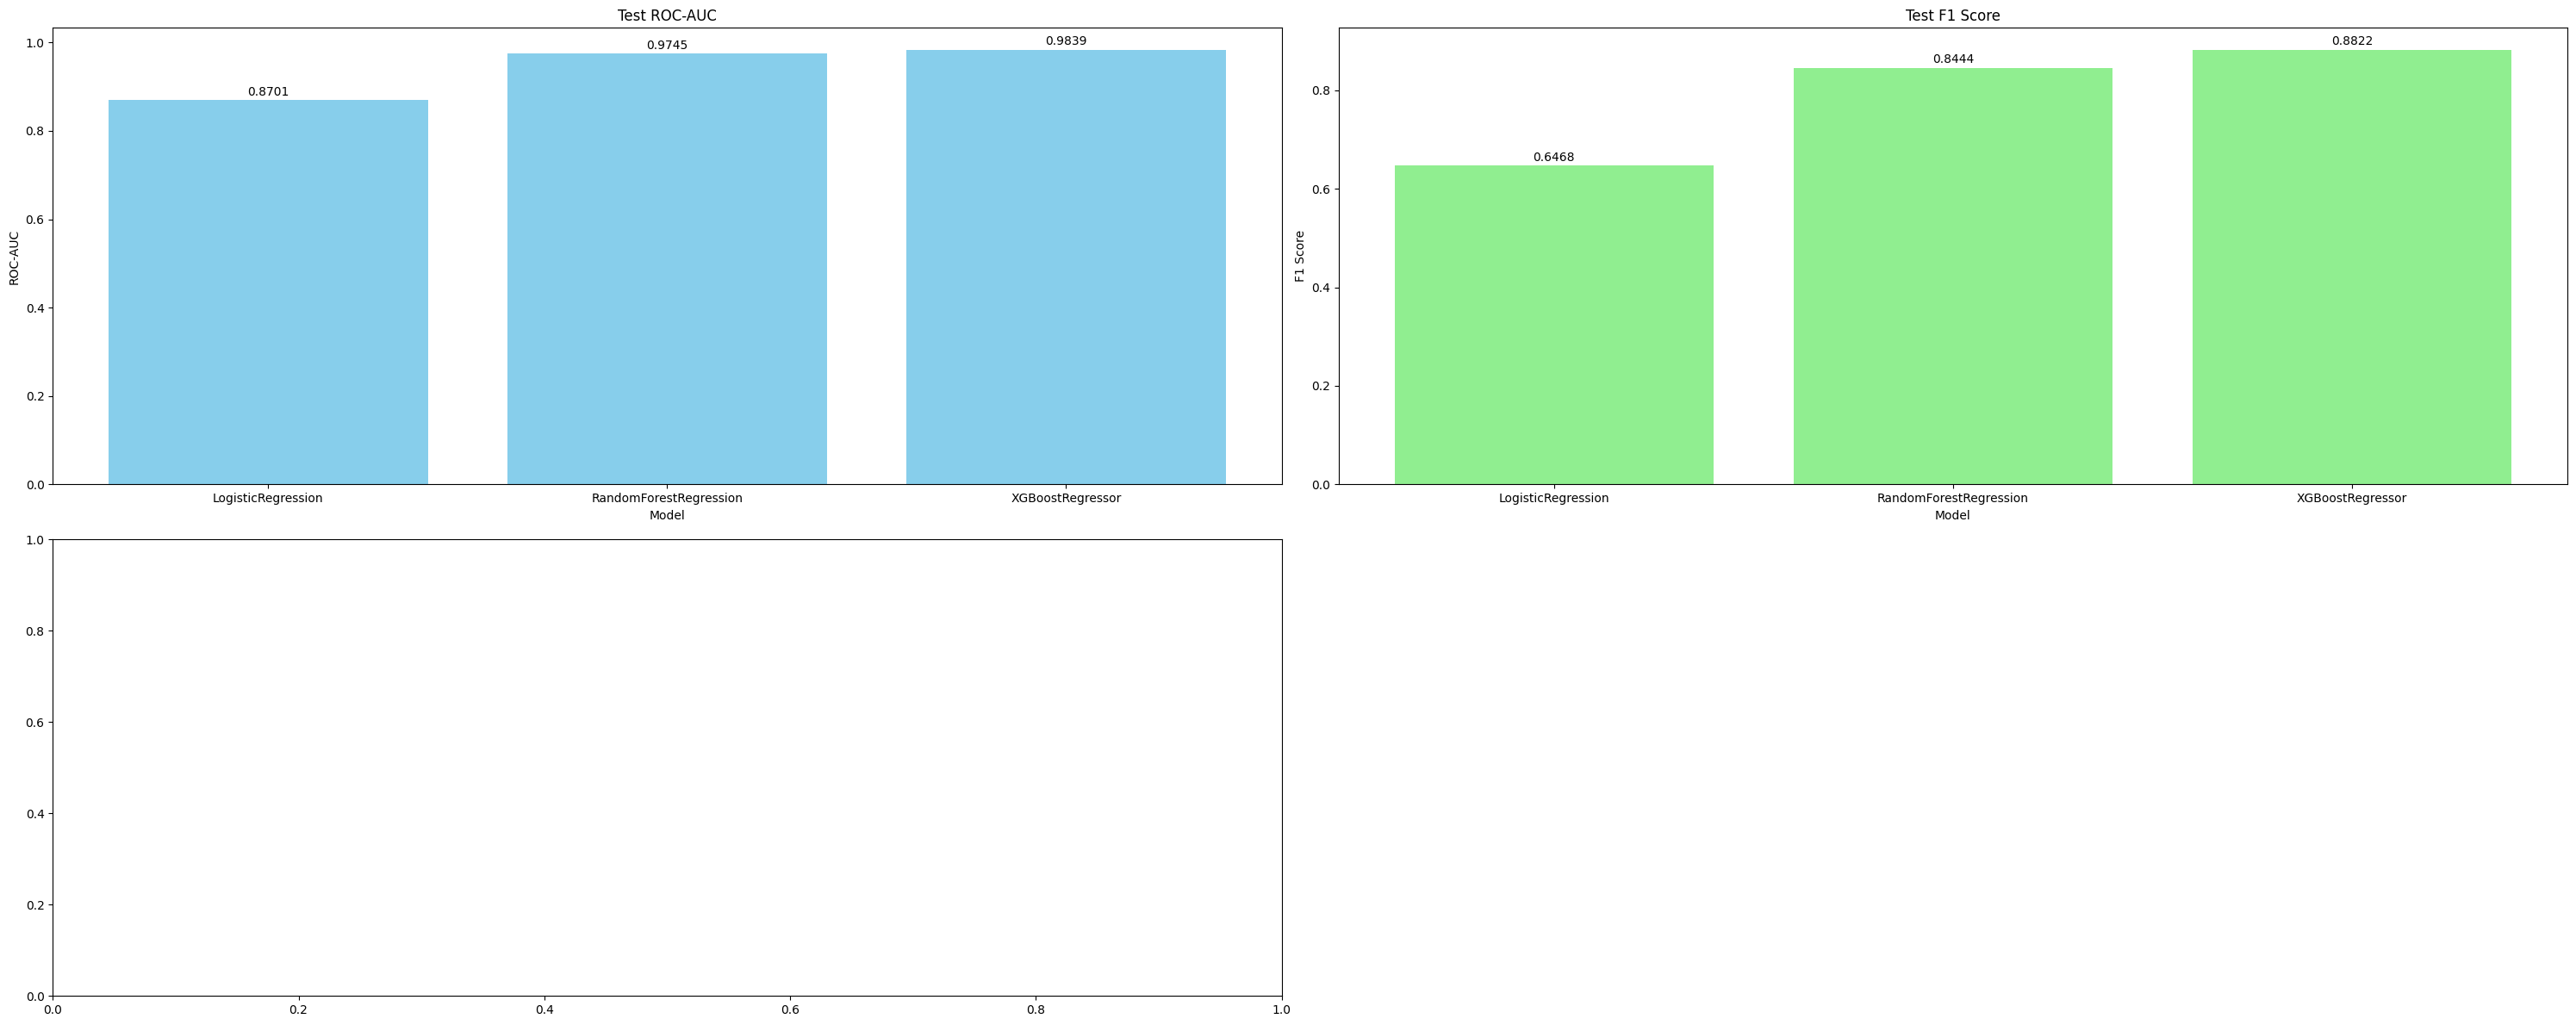

In [ ]:
model_names = ['LogisticRegression', 'RandomForestRegression', 'XGBoostRegressor']  # Added missing comma
test_roc_auc = [0.8701, 0.9745, 0.9839]
test_f1 = [0.6468, 0.8444, 0.8822]

# Create a figure with 3 subplots
fig, axs = plt.subplots(2, 2, figsize=(30, 12))

# Plot the test ROC-AUC for each model
axs[0, 0].bar(model_names, test_roc_auc, color='skyblue')
axs[0, 0].set_title('Test ROC-AUC')
axs[0, 0].set_xlabel('Model')
axs[0, 0].set_ylabel('ROC-AUC')
for i, value in enumerate(test_roc_auc):
    axs[0, 0].text(i, value + 0.01, f'{value:.4f}', ha='center')  # Adjusted the position

# Plot the test F1 Score for each model
axs[0, 1].bar(model_names, test_f1, color='lightgreen')
axs[0, 1].set_title('Test F1 Score')
axs[0, 1].set_xlabel('Model')
axs[0, 1].set_ylabel('F1 Score')
for i, value in enumerate(test_f1):
    axs[0, 1].text(i, value + 0.01, f'{value:.4f}', ha='center')  # Adjusted the position

# Remove the empty subplot
fig.delaxes(axs[1, 1])

# Layout so plots do not overlap
fig.tight_layout()

plt.show()

**Comment:**

In this section, I wanted to achieve the optimal score of ROC-AUC > 0.88 using a two-part approach. The first part is to evaluate the baseline results of three models with increasing complexity by using RandomizedSearchCV. Then, investigate the feature importance and do additional preprocessing (part of Feature Engineering II).

The results were that the model performance benefits from gradient boosting as demonstrated by the 98% ROC-AUC from XGBClassifier(). LogisticRegression() performed well, but was at the bottom of the performance threshold for the assignment. RandomForestClassifier() had noticeable improvement, but still did not achieve the mark even with the best parameters function I integrated early into the ML assignments.

After these reuslts, I tried to boost the performance once more by stripping out other fields from the model inputs or features, and found that it had the inverse effect. They signficantly detracted from the ROC-AUC.



## **Feature Importance**

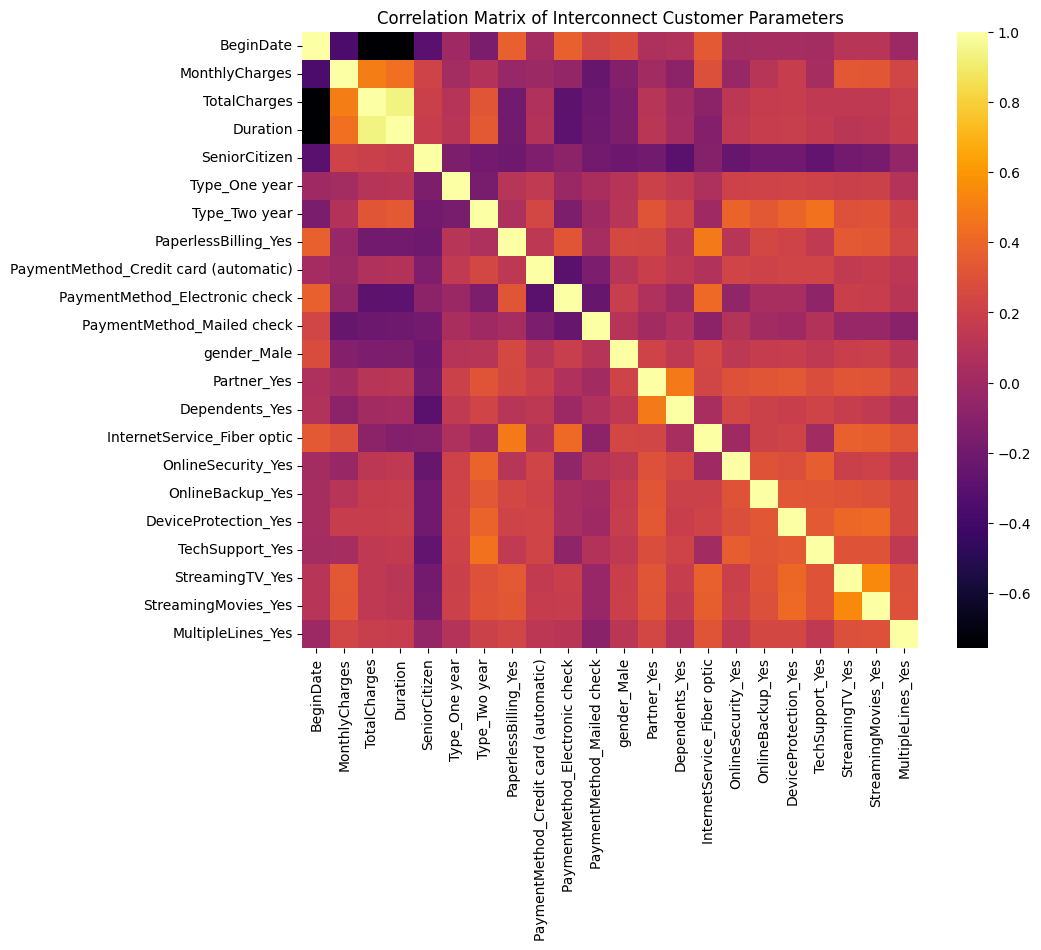

In [ ]:
# Add correlation matrix sns
# Calculate the Kendall's tau correlation matrix
corr_matrix = interconnect_customer_data[feature_names].corr(method='kendall')

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='inferno', square=True)
plt.title('Correlation Matrix of Interconnect Customer Parameters')
plt.show()

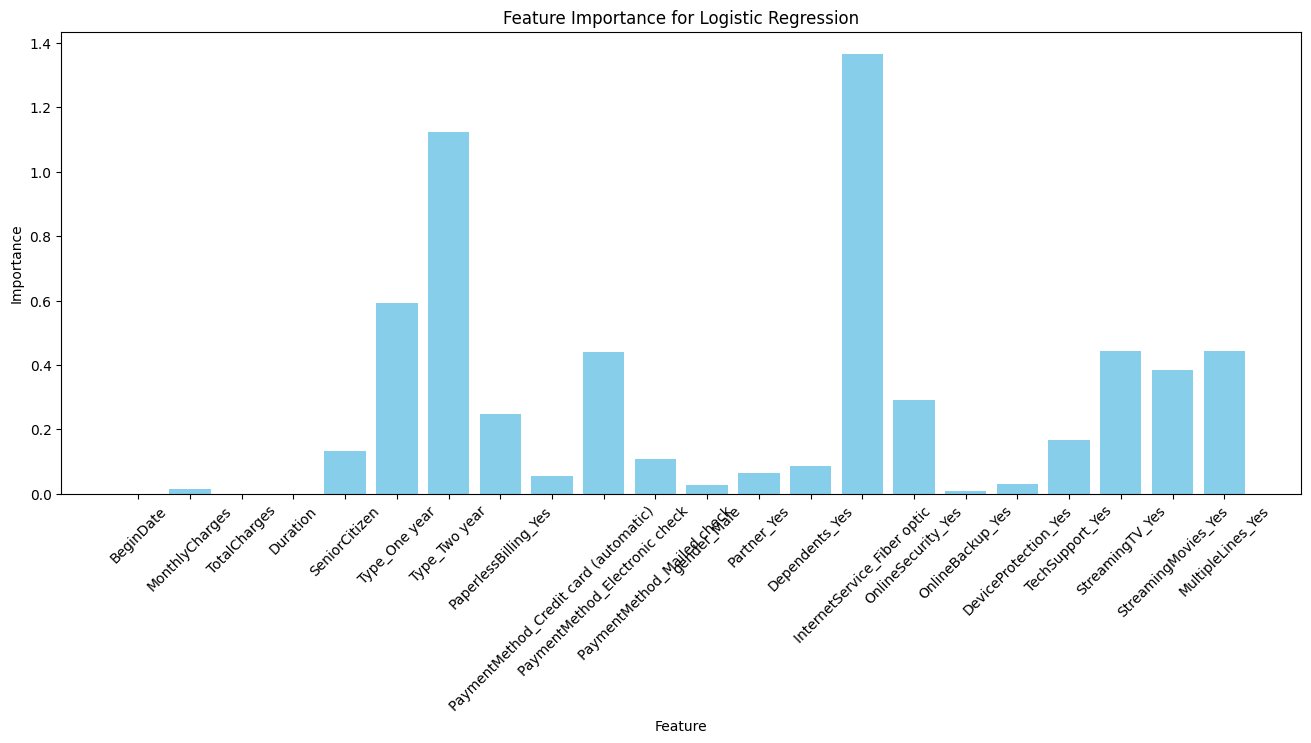

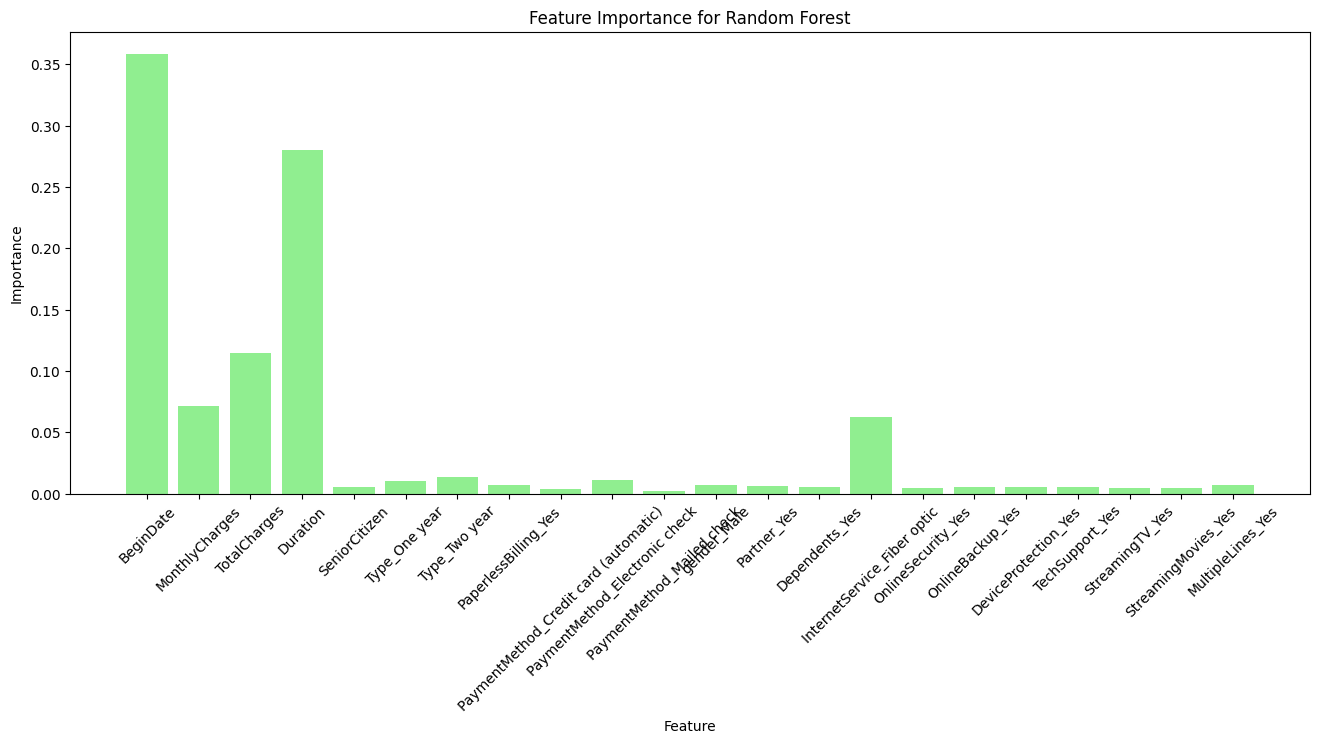

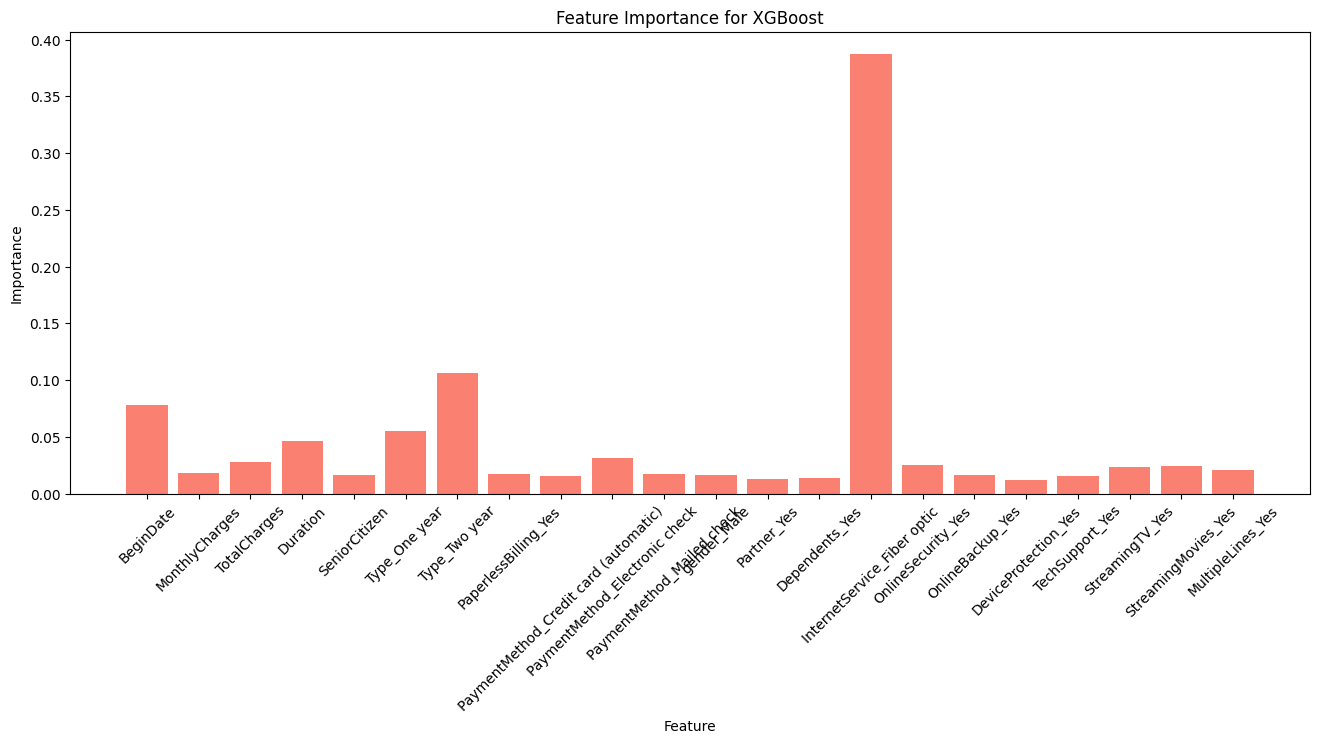

In [ ]:
# Assuming you have already trained your models and have the following:
# best_model1, best_model2, best_model3 are your trained models for Logistic Regression, Random Forest, and XGBoost respectively.

# Get feature names
feature_names = features_train.columns

# Extract feature importance for each model
# For Logistic Regression, we can use the absolute values of the coefficients
feature_importance1 = np.abs(best_model1.coef_[0])  # For Logistic Regression

# For Random Forest, use the feature_importances_ attribute
feature_importance2 = best_model2.feature_importances_  # For Random Forest

# For XGBoost, use the feature_importances_ attribute
feature_importance3 = best_model3.feature_importances_  # For XGBoost

# Plot feature importance for Logistic Regression
plt.figure(figsize=(16, 6))
plt.bar(feature_names, feature_importance1, color='skyblue')
plt.title("Feature Importance for Logistic Regression")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=45)  # Rotate feature names for better readability
plt.show()

# Plot feature importance for Random Forest
plt.figure(figsize=(16, 6))
plt.bar(feature_names, feature_importance2, color='lightgreen')
plt.title("Feature Importance for Random Forest")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=45)  # Rotate feature names for better readability
plt.show()

# Plot feature importance for XGBoost
plt.figure(figsize=(16, 6))
plt.bar(feature_names, feature_importance3, color='salmon')
plt.title("Feature Importance for XGBoost")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=45)  # Rotate feature names for better readability
plt.show()

                                  Feature  Importance
2                            TotalCharges    0.409819
3                                Duration    0.270306
0                               BeginDate    0.169704
1                          MonthlyCharges    0.115266
6                           Type_Two year    0.012333
14            InternetService_Fiber optic    0.009217
19                        StreamingTV_Yes    0.001938
16                       OnlineBackup_Yes    0.001885
7                    PaperlessBilling_Yes   -0.000052
10             PaymentMethod_Mailed check   -0.000052
20                    StreamingMovies_Yes   -0.000105
15                     OnlineSecurity_Yes   -0.000550
4                           SeniorCitizen   -0.001335
13                         Dependents_Yes   -0.001388
11                            gender_Male   -0.001571
5                           Type_One year   -0.001702
18                        TechSupport_Yes   -0.001781
17                   DeviceP

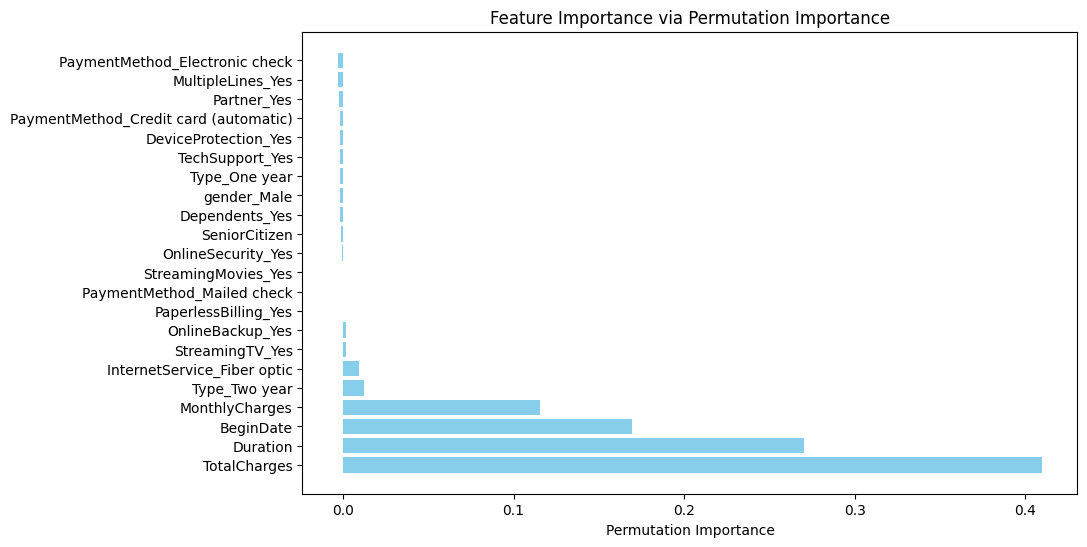

In [ ]:
# Assume you have already imported necessary libraries and defined your model and performed hyperparameter tuning

# Calculate permutation importance
results = permutation_importance(best_model3, features_test, target_test, n_repeats=30, random_state=42, n_jobs=-1)

# Create a DataFrame to hold the feature importances
importance_df = pd.DataFrame({'Feature': features_train.columns, 'Importance': results.importances_mean})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(importance_df)

# Optionally, you can visualize the feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Permutation Importance')
plt.title('Feature Importance via Permutation Importance')
plt.show()

**Comment:**

To end off the assignment, I wanted to investigate which features would be most impactful in predicting churn, so I used a basic feature importance, then a permuation test.

The findings were that the models have distinct feature profiles with some similarities to each other. The combination of high total charges, when a customer's contract began, and similarly, the duration of the contract appear to strongly influence whether a person will churn. The presence of dependents has an influence across models as well.

## **Conclusion**

We found that the customer data provided is appropriate to develop a ML predicition model. The results were that using a gradient boosting method, we can achieve 98% predicition of customer behavior to leave or keep their contract. Based on our investigation of feature importance, we can optimize our marketing to longer-term financial incentives for both single and family customers.